<h1><center><font color=darkcyan>  TP d'Apprentissage statistiques sur les données biologiques </font></center></h1>

<h2><center><font color=darkorange> Application aux arbres et aux SVM</font></center></h2>

<lu>
    <li><font color=darkblue> SOPGOUI MBEUKAM Lionel</font></li>
    <li><font color=darkblue> ADDASSI Youssef</font></li>
</lu>
<hr>

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

import warnings
warnings.filterwarnings("ignore")

### Question 1 : Chargement et préparation des données

In [2]:
label = pd.read_csv('GSE17924_series_matrix.txt',sep='\t',index_col=0)
label = label.transpose()
label = label["severity"]

#### On enlève les sévérités DHF dans les données

In [3]:
msk = ~(label == "severity: DHF")

In [4]:
dataOrg = pd.read_csv('GSE17924_series_matrix.txt',sep='\t',index_col=0, skiprows=21)
dataOrg = dataOrg.transpose()
dataOrg = dataOrg[msk]
dataOrg.head()

,12,13,14,15,16,17,18,19,20,21,...,45200,45201,45202,45203,45204,45205,45206,45207,45208,45209
GSM447781,11.519934,6.915259,9.818105,5.371255,11.843452,4.810572,7.450713,14.397061,5.763549,4.984783,...,5.252327,10.047690,8.234652,13.762584,4.728840,6.430334,9.537699,2.745445,2.735733,9.696610
GSM447782,10.266369,6.584705,10.149880,5.462203,11.636645,4.863805,7.495921,14.840463,5.832707,5.497416,...,5.202092,10.436165,7.862535,13.666809,4.914479,8.071005,10.409059,3.043695,2.825944,9.847350
GSM447783,11.517425,6.336898,9.712470,5.873331,11.452921,3.893979,7.288172,14.405493,6.228280,4.320078,...,6.325055,9.824410,8.270700,13.628572,5.813508,7.943193,9.742599,5.692912,5.057673,9.879107
GSM447784,11.963806,5.881100,9.836638,4.544681,12.135660,5.605158,7.279210,15.060383,5.757566,4.385994,...,4.642562,10.524205,9.303061,13.481760,4.608364,6.823640,10.768028,2.447080,2.593118,10.984354
GSM447786,12.407864,7.346544,10.485600,6.158914,12.140635,4.729529,6.950945,14.660080,5.301891,4.351304,...,5.733378,9.522212,8.506282,14.262629,7.424536,7.967575,9.776831,3.795896,4.468312,9.091121


In [5]:
annotations = pd.read_csv('GPL4133-12599.txt',sep='\t',index_col=0, skiprows=22)
annotations = annotations["GENE_NAME"]
annotations.dropna(inplace=True)

#### Préparation des labels

In [6]:
label = label[msk]
label = label.replace("severity: DF", 0)
label = label.replace("severity: DSS", 1)
label = pd.DataFrame(label, dtype="int")

## Question 2-a : Calcul et visualisation de la moyenne et de la variance, puis réduction des données

In [7]:
dataOrg.loc['mean',:] = dataOrg.mean()

In [8]:
dataOrg.loc['var',:] = dataOrg.var()

In [9]:
dataOrg.tail(2)

,12,13,14,15,16,17,18,19,20,21,...,45200,45201,45202,45203,45204,45205,45206,45207,45208,45209
mean,12.025593,6.692013,10.198048,5.421742,12.019067,4.710428,7.314017,14.497992,5.659526,4.277186,...,5.536861,10.054220,8.443321,13.679740,5.658202,7.665657,10.133459,3.057689,3.061138,9.598928
var,0.527839,0.207675,0.145429,0.329876,0.182844,0.891690,0.056523,0.463350,0.693058,1.174477,...,0.185226,0.341027,0.131834,0.160057,0.694103,0.343572,0.430101,0.655900,0.662575,0.589078


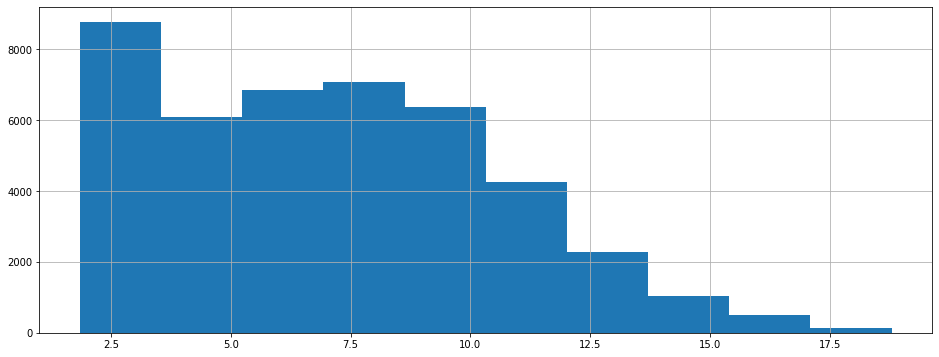

In [10]:
plt.figure(figsize=(16,6))
dataOrg.loc['mean',:].hist()
plt.show()

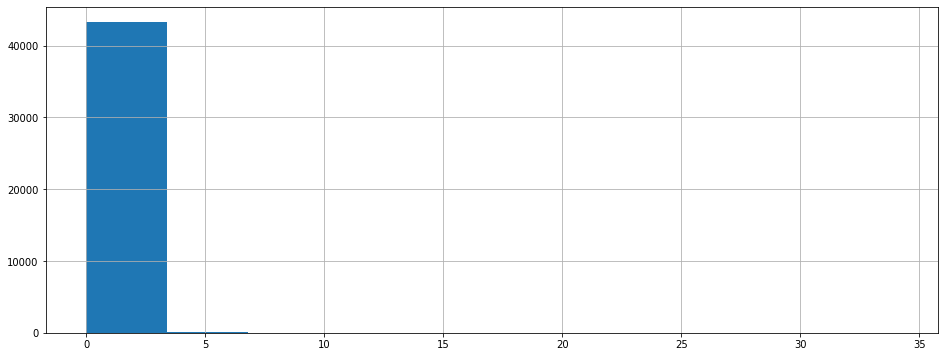

In [11]:
plt.figure(figsize=(16,6))
dataOrg.loc['var',:].hist()
plt.show()

In [12]:
S = dataOrg.loc['mean',:]>3

In [13]:
T = dataOrg.loc['var',:]>2

In [14]:
dataOrg = dataOrg.loc[:,S]
dataOrg = dataOrg.loc[:,T]

## Question 3  : Selection des classifiers

### On décide de choisir 8 principaux classifieurs :
<ol>
    <li>Arbres de décision</li>
    <li>Boosting</li>
    <li>Forêts aléatoires</li>
    <li>Regression logistique</li>
    <li>SVM linéaire</li>
    <li>SVM gaussien</li>
    <li>kNN</li>
    <li>Vote majoritaire</li>
    </ol>

In [15]:
y = label["severity"]
X = dataOrg[:35]

### 1- Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
dec_trees = DecisionTreeClassifier(random_state=0)
dec_trees.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

### 2- Boosting

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
boosting = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
boosting.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### 3- Random Forests

In [18]:
from sklearn.ensemble import RandomForestClassifier
random_forests = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
random_forests.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### 4- Logistic regression

In [19]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### 5- SVM without Kernel (linear SVM)

In [20]:
from sklearn.svm import SVC
svm_no_kernel = SVC(kernel='linear', gamma='auto', probability=True)
svm_no_kernel.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

### 6- SVM with Gaussian Kernel

In [21]:
from sklearn.svm import SVC
svm_with_kernel = SVC(gamma='auto', probability=True)
svm_with_kernel.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

### 7- kNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

### 8- qui donne pour résultat le vote majoritaire de l'ensemble de ces méthodes.

In [23]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators = [('treeclf',dec_trees), 
                                        ('boosting',boosting), 
                                        ('randomforest',random_forests), 
                                        ('linearkernel', svm_no_kernel), 
                                        ('gaussiankernel',svm_with_kernel), 
                                        ('logisticregression',log_reg),
                                        ('knn', neigh)],
                          voting='soft')
voting.fit(X,y)

VotingClassifier(estimators=[('treeclf',
                              DecisionTreeClassifier(class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort=False,
                                                     random_state=0,
                                                     splitter='best')),
    

# 4-a Performance prédictive par validation croisée

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from collections import defaultdict

classifiers={'KNN':neigh,
             'LogisticRegression':log_reg,
             'boosting':boosting,             
             'LinearKernel':svm_no_kernel,
             'GaussianKernel':svm_with_kernel,
             'treeclf':dec_trees,
             'RandomForest':random_forests,
             'voting':voting}
loo=LeaveOneOut()
score_dict=defaultdict(list)
for name, classifier in classifiers.items():
    score_dict[name].append(cross_val_score(classifier,X, y,cv=5))
    print("MEAN SCORE of " +str(name) + "   ==>>    " + str(score_dict[name][0].mean()))

MEAN SCORE of KNN   ==>>    0.8845238095238095
MEAN SCORE of LogisticRegression   ==>>    0.8511904761904763
MEAN SCORE of boosting   ==>>    0.8595238095238095
MEAN SCORE of LinearKernel   ==>>    0.8511904761904763
MEAN SCORE of GaussianKernel   ==>>    0.7404761904761904
MEAN SCORE of treeclf   ==>>    0.8845238095238095
MEAN SCORE of RandomForest   ==>>    0.9130952380952382
MEAN SCORE of voting   ==>>    0.9130952380952382


 ### Conclusion : 
 #### ce sont les méthodes "par vote majoritaire" et "fôrets aléatoires" qui donnent les meilleurs prédictions avec un score de 91.30%.

# 4-b Performance prédictive par la courbe AUC

In [25]:
def ConfInterAUC(auc,z_halfAlpha, dfphenotypes):
    ncases=dfphenotypes.sum()
    ncontroles=len(dfphenotypes)-ncases
    z=z_halfAlpha
    qcontroles=auc/(2-auc)
    qcases=2*pow(auc,2)/(1+auc)
    SE_auc=np.sqrt((auc*(1-auc)+(ncontroles-1)*(qcontroles-pow(auc,2))+(ncases-1)*(qcases-pow(auc,2)))/(ncases*ncontroles))
    CI_auc=z*SE_auc
    return(CI_auc)

### Calcul et affichage de la courbe AUC

Confident interval under ROC curve for KNN ==>>   [0.7159687062527587 , 0.9846891884840834]
Confident interval under ROC curve for LogisticRegression ==>>   [0.8164885776957883 , 1]
Confident interval under ROC curve for boosting ==>>   [0.8718494656836703 , 1]
Confident interval under ROC curve for LinearKernel ==>>   [0.8112547810475984 , 1]
Confident interval under ROC curve for GaussianKernel ==>>   [0.3586592778164106 , 0.7466038800783261]
Confident interval under ROC curve for treeclf ==>>   [0.6773961049649895 , 0.9673407371402736]
Confident interval under ROC curve for RandomForest ==>>   [0.8270944791635958 , 1]
Confident interval under ROC curve for voting ==>>   [0.8009141294091564 , 1]


Text(0, 0.5, 'True Positive Rate')

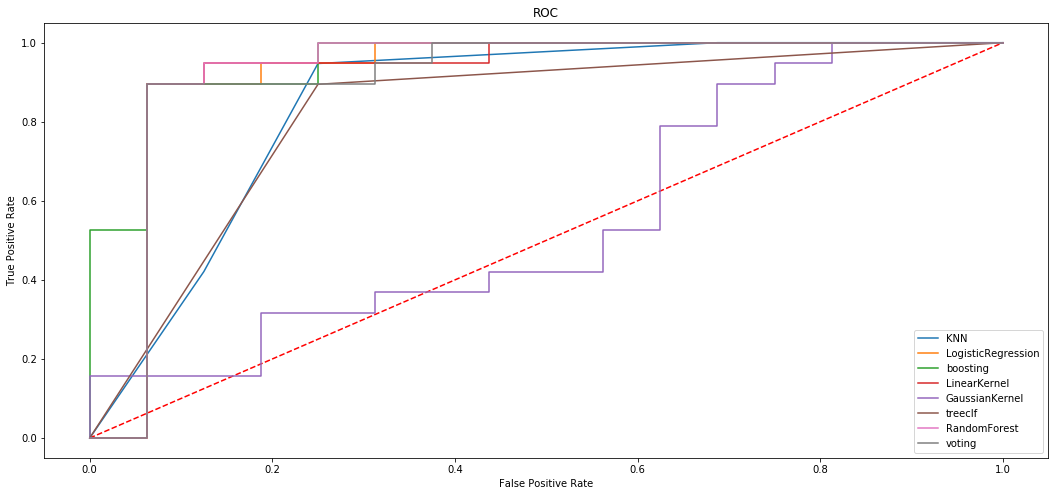

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

proba_dict=defaultdict(list)
plt.figure(figsize = (18,8))

for train_index, test_index in loo.split(X):
    X_train,X_test = pd.DataFrame(X.iloc[train_index,:]),pd.DataFrame(X.iloc[test_index,:])
    Y_train,Y_test = pd.DataFrame(y[train_index]).astype(int),pd.DataFrame(y[test_index]).astype(int)
    for name,classifier in classifiers.items():
        classifier.fit(X_train,np.asarray(Y_train).ravel())
        Y_pred_proba = classifier.predict_proba(X_test)
        proba_dict[name].append(Y_pred_proba[0][1])
        
plt.plot([0,1],[0,1],'r--')
plt.title('ROC')
for name, classifier in classifiers.items():
    fpr , tpr , thresolds = roc_curve(y,proba_dict[name])
    plt.plot(fpr,tpr,label = f"{name}")
    auc = roc_auc_score(y,proba_dict[name])
    demiIntervalle = ConfInterAUC(auc,1.96,y)
    print("Confident interval under ROC curve for " + str(name) +" ==>>   [" +str(max(0,auc - demiIntervalle)) + " , " +str(min(1,auc + demiIntervalle)) + "]" )

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

 ### Conclusion : 
 #### c'est la méthode "BOOSTING" qui donne la meilleure intervalle de confiance pour l'aire sous la corbe ROC avec [0.87 , 1.00]

# 4- c 
### - L'intervalle de d'incertitude calculé : décrit la probablité que l'aire sous la courbe ROC soit dans l'intervalle est supérieure à 95%.
### - La courbe ROC décrivant le taux de vrais positifs en fonction du taux de faux positifs, on déduit qu'elle ne tient pas compte des faux positifs et des faux négatifs. Ce n'est pas forcément rassurant quant à la robustesse, on pourrait penser que le calcul du SCORE F1 est plus robuste.

# 5- Comparaison des modèles

#### Feature max pour les forets aléatoires

In [27]:
k = np.argmax(random_forests.feature_importances_)
X.transpose()[k:k+1].index[0]

9308

#### Feature max pour la régression logistique

In [28]:
k = np.argmax(log_reg.coef_)
X.transpose()[k:k+1].index[0]

22449

#### Parameters for SVM with linear kernel

In [29]:
len(svm_no_kernel.support_)

26

#### Parameters for SVM with gaussian kernel

In [30]:
len(svm_with_kernel.support_)

34

<ol>
    <li>Arbres de décision</li>
    <li>Boosting</li>
    Avec une précision de 86% environ et un AUC dans [0.8718494656836703 , 1], boosting donne des résultats très intéressants, mais il serait difficile de les interpreter à cause de la manière dont la méthode est théoriquement construite.
    <li>Forêts aléatoires</li>
    En termes de précisions, 91% est la meilleure performance obenue et l'AUC min n'est pas mal. On constate aussi que le transcrit le plus important lors de la classification est celui à l'index 9308.
    <li>Regression logistique</li>
    La précision et l'AUC min de la régression logistique sont assez bonnes ici, à chaque fois supérieure à 0.80. On constate aussi que le transcrit le plus important lors de la classification est celui à l'index 22449.
    <li>SVM linéaire</li>
    La précision et l'AUC min de la régression logistique sont assez bonnes comme ceux de la régression logistique. On constat en plus qu'on a 26 vecteurs supports à la fin sur les 35 du départ, ce n'est pas très grand, mais vu la taille de notre échantillon (35), 26 reste un valeur intéressante.
    <li>SVM gaussien</li>
    La précision et l'AUC sont les moins bons parmi les 8 classifieurs implémentés. On constate de plus qu'il y a 34 vecteurs supports sur les 35 possibles. L'utilisation du noyau gaussien ici est très insatisfaisante.
    <li>kNN</li>
    Le nombre de voisin optimal est 3. C'est une méthode assez intuitive qui donne de bons résultats en général.
    <li>Vote majoritaire</li>
    Le vote majoritaire donne des résultats très proches des forêts aléatoires, ce qui s'explique par la plupart des méthodes étudiées ont des précisions proches de 80%. Et que le vote majoritaire moyenne avec les mêmes poids les autres méthodes.
    </ol>

 # 5 - Comparaison des classifiers

### - Leav-one-out :
C'est une méthode de validation qui consiste à diviser un échantillon N de données en N sous-échantillons tels que pour chaque sous-échantillon i dans N, on a N-1 données d'apprentissage et 1 donnée de test.

### - Avantages par rapport à k-fold cross validation pour les petis échantillons
#### 1 - Parce qu'il n y a pas de variance
#### 2 - Permet de faire plus de tests de validation du modèle car en prenant k-fold, on aurait que ${N}\choose{k}$ $ < N$, cela assure la robustesse du test de validation.


<h2><center><font color=darkorange> Fin du TP </font></center></h2>